In [285]:
import numpy as np

class ImageBuffer(object):

    # idx starts from 1. The first image will have idx 1.
    # When the buffer get full with batch size 100, then there will be 100 iamges and the current idx will be 100.

    def __init__(self, height, width, stepsize, channel_size, buffer_size):
        self.height = height
        self.width = width
        self.stepsize = stepsize
        self.channel_size = channel_size
        self.step_channelsize = stepsize * channel_size

        self.buffer = []
        self.buffer_size = buffer_size
        self.count = 0

        assert self.stepsize <= self.buffer_size

        self.start_adjust = (self.stepsize - 1)
        self.full_count = 0

        for _ in range(stepsize):
            self.buffer.append(np.zeros([channel_size,height,width]))


    # [height, width, channel]
    def dm_add(self, frame):
        frame = np.moveaxis(frame, [0, 1, 2], [1, 2, 0])
        if self.count < self.buffer_size:
            self.count += 1
            self.buffer.append(frame)
        else:
            self.buffer.pop(0)
            self.buffer.append(frame)
            self.full_count += 1

    def get_state(self, idx):
        assert idx > 0 and idx <= self.count + self.full_count

        if self.count < self.buffer_size:
            temp_idx = idx + self.start_adjust
        else:
            temp_idx = idx + self.start_adjust - self.full_count

        assert temp_idx > self.start_adjust

        return_array = np.concatenate(self.buffer[temp_idx - self.start_adjust: temp_idx + 1], axis=0)

        print(return_array.shape)

        assert return_array.shape == (self.step_channelsize, self.height, self.width)

        return return_array
        #[stepsize, height, width]

    def get_state_and_next(self, idx):
        assert idx > 0 and idx < self.count + self.full_count
        return self.get_state(idx), self.get_state(idx+1)

In [286]:
base = np.ones([48,64,3])

In [312]:
a = ImageBuffer(48, 64, 10, 3, 10)

In [313]:
for i in range(1,11):
    a.dm_add(base*i)

In [319]:
a.dm_add(base*11)

In [326]:
a.get_state(1)[-6]

AssertionError: 

In [330]:
buffer_size = 2e5

In [331]:
buffer_size*1.01

202000.0

In [240]:
for i in range(1,8):
    a.dm_add(i)

In [242]:
a.get_state(7)

array([0, 0, 0, 1, 2, 3, 4, 5, 6, 7])

In [209]:
a.dm_add(1)

print(a.get_state(1))

print (a.count)
print (a.full_count)

[0 0 1]
1
0


In [210]:
a.dm_add(2)

print(a.get_state(2))

print (a.count)
print (a.full_count)

[0 1 2]
2
0


In [211]:
a.dm_add(3)

print(a.get_state(3))

print (a.count)
print (a.full_count)

[1 2 3]
3
0


In [212]:
a.dm_add(4)

print(a.get_state(4))

print (a.count)
print (a.full_count)

[2 3 4]
3
1


In [213]:
a.dm_add(5)

print(a.get_state(5))

print (a.count)
print (a.full_count)

[3 4 5]
3
2


In [214]:
a.dm_add(6)

print(a.get_state(6))

print (a.count)
print (a.full_count)

[4 5 6]
3
3


In [218]:
print(a.get_state(6))

[4 5 6]


In [206]:
a.buffer

[1, 2, 3, 4, 5, 6]

In [1]:
from dm_control import suite
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
env = suite.load(domain_name="cartpole",task_name="swingup")

In [9]:
frame = env.physics.render(camera_id=0, width=64, height=48)

In [10]:
frame.shape

(48, 64, 3)

In [11]:
np.moveaxis(frame,[0,1,2],[1,2,0]).shape

(3, 48, 64)

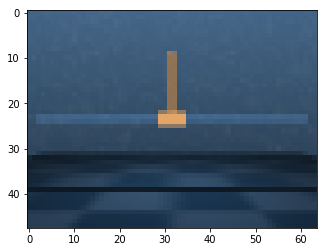

In [12]:
plt.imshow(frame)

In [56]:
conv1 = torch.nn.Conv2d(in_channels = 3, out_channels= 256,
                                     kernel_size= 3, stride= 2, padding= 1)
conv2 = torch.nn.Conv2d(in_channels=256, out_channels=128,
                                     kernel_size=3, stride=2, padding=1)
conv3 = torch.nn.Conv2d(in_channels=128, out_channels=64,
                                     kernel_size=3, stride=2, padding=1)
conv4 = torch.nn.Conv2d(in_channels=64, out_channels=32,
                                     kernel_size=3, stride=2, padding=1)

In [57]:
frame = frame / 255 - 0.5

In [58]:
cv1 = conv1(torch.FloatTensor(frame).view([1,3,48,64]))

In [59]:
cv1.shape

torch.Size([1, 256, 24, 32])

In [60]:
cv2 = conv2(cv1)

cv2.shape

torch.Size([1, 128, 12, 16])

In [61]:
cv3 = conv3(cv2)

cv3.shape

torch.Size([1, 64, 6, 8])

In [62]:
cv4 = conv4(cv3)

cv4.shape

torch.Size([1, 32, 3, 4])

In [63]:
fc1 = cv4.view([1,-1])
fc1.shape

torch.Size([1, 384])

In [18]:
import numpy as np

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

class VanillaSACPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, lr, device):
        super(VanillaSACPolicy, self).__init__()

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.actor_lr = lr
        self.device = device


        self.fc1 = nn.Linear(state_dim, 256).to(device)
        self.fc2 = nn.Linear(256, 256).to(device)
        self.mu = nn.Linear(256, action_dim).to(device)
        self.log_std = nn.Linear(256, action_dim).to(device)

        nn.init.uniform_(tensor=self.mu.weight, a = -3e-3, b=3e-3)
        nn.init.uniform_(tensor=self.mu.bias, a=-3e-3, b=3e-3)

        nn.init.uniform_(tensor=self.log_std.weight, a=-3e-3, b=3e-3)
        nn.init.uniform_(tensor=self.log_std.bias, a=-3e-3, b=3e-3)

        self.optimizer = optim.Adam(self.parameters(),lr)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        mu = F.relu(self.mu(x))
        log_std = F.relu(self.log_std(x))
        

        # It should return mu, log_std

        return mu, log_std

    def sample_with_logp(self, x):
        mu, log_std = self.forward(x)
        std = torch.exp(log_std)

        normal = Normal(mu, std)
        x_t = normal.rsample()
        logp = normal.log_prob(x_t)

        y_t = torch.tanh(x_t)
        logp -= torch.log(1 - torch.pow(y_t, 2) + 1e-6)
        
        return y_t, logp
    
    def sample(self, x):
        mu, log_std = self.forward(x)
        std = torch.exp(log_std)
        
        normal = Normal(mu, std)
        
        return normal.sample()

In [22]:
x,y = torch.FloatTensor([[1,2],[3,4]])

In [23]:
x

tensor([1., 2.])

In [24]:
y

tensor([3., 4.])

In [2]:
t = VanillaSACPolicy(1,1,1e-4,torch.device("cuda"))

In [3]:
mu, log_std = t.forward(torch.FloatTensor([0.0]).to(torch.device("cuda")))

In [12]:
k = t.sample_with_logp(torch.FloatTensor([0.0]).to(torch.device("cuda")))

In [13]:
k

(tensor([0.9147], device='cuda:0', grad_fn=<TanhBackward>),
 tensor([-0.3063], device='cuda:0', grad_fn=<SubBackward0>))

In [ ]:
kk = torch.sum(k)

In [ ]:
kk.backward()

In [ ]:
t.fc3.weight.grad[0][:20]

In [ ]:
with torch.no_grad():
    a = t.forward(torch.FloatTensor([1.0]).to(torch.device("cuda")))
    aa = torch.mean(a)
    aa.backward()

In [ ]:
a = t.forward(torch.FloatTensor([1.0]).to(torch.device("cuda")))
aa = torch.mean(a)
aa.backward()

In [ ]:
t.fc3.weight.grad[0][:20]

In [ ]:
a = t.forward(torch.FloatTensor([1.0]).to(torch.device("cuda")))
aa = torch.mean(a, dim=2,keepdim=True)

In [ ]:
aa.shape

In [ ]:
a.shape

In [ ]:
aa.grad_fn

In [ ]:
k = aa.detach()

In [ ]:
k.grad_fn

In [5]:
torch.min(torch.rand([128,2]),dim=1,keepdim=True)[0]

tensor([[0.1811],
        [0.7346],
        [0.4839],
        [0.1855],
        [0.6389],
        [0.5600],
        [0.8725],
        [0.0774],
        [0.1786],
        [0.0405],
        [0.1197],
        [0.6140],
        [0.3378],
        [0.2630],
        [0.4949],
        [0.6667],
        [0.1536],
        [0.5285],
        [0.5524],
        [0.6668],
        [0.5157],
        [0.2751],
        [0.0645],
        [0.5010],
        [0.5977],
        [0.4375],
        [0.1291],
        [0.3220],
        [0.1322],
        [0.1771],
        [0.4315],
        [0.4381],
        [0.0357],
        [0.2574],
        [0.1699],
        [0.0811],
        [0.1572],
        [0.1574],
        [0.0391],
        [0.6168],
        [0.4212],
        [0.5758],
        [0.4226],
        [0.6369],
        [0.3919],
        [0.0097],
        [0.7571],
        [0.6575],
        [0.0659],
        [0.5496],
        [0.7785],
        [0.7828],
        [0.3180],
        [0.7035],
        [0.5237],
        [0